# Mount Drive to access data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import all packages

In [1]:
import math
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
#from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


# Load data and split for training and testing

In [4]:
#load data
#path for colab
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My ML Projects/Combined_News_DJIA.csv', delimiter=',')
#path for local vs code
data = pd.read_csv('Combined_News_DJIA.csv', delimiter=',')

#split data
x_train = data[0:math.floor(0.81*1989)]
x_test = data[math.floor(0.81*1989):1989]

#use only the top 1 comment for simplicity
#x_train= x_train.iloc[:,2]
#x_test= x_test.iloc[:,2]

#create single column from all top 25 comments
x_train_temp_vector_all25 = []
for row in range(0,len(x_train.index)):
    x_train_temp_vector_all25.append(' '.join(str(x) for x in x_train.iloc[row,2:27]))
x_test_temp_vector_all25 = []
for row in range(0,len(x_test.index)):
    x_test_temp_vector_all25.append(' '.join(str(x) for x in x_test.iloc[row,2:27]))

#define target
y_train = data['Label'][0:math.floor(0.81*1989)]
y_test = data['Label'][math.floor(0.81*1989):1989]

# Preprocessing textual data

In [5]:
#transform strings
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

#store transformed strings in new vectors
x_train_tr = []
for i in x_train_temp_vector_all25:
    x_train_tr.append(preprocess_text(i))

x_test_tr = []
for i in x_test_temp_vector_all25:
    x_test_tr.append(preprocess_text(i))

#delete old vectors
del(x_train_temp_vector_all25, x_test_temp_vector_all25)

#convert textual data into numbers
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train_tr)

x_train_tr = tokenizer.texts_to_sequences(x_train_tr)
x_test_tr = tokenizer.texts_to_sequences(x_test_tr)

# Adjust length of the created word vectors

In [6]:
#Each list actually corresponds to each sentence in the training set. 
#You will also notice that the size of each list is different. 
#This is because sentences have different lengths.

#We set the maximum size of each list to 50. You can try a different size. 
#The lists with size greater than 50 will be truncated to 50. 
#For the lists that have length less than 50, we will add 0 at the end of the 
#list until it reaches the max length. This process is called padding.

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

x_train_tr = pad_sequences(x_train_tr, padding='post', maxlen=maxlen)
x_test_tr = pad_sequences(x_test_tr, padding='post', maxlen=maxlen)


# Create the feature matrix

In [ ]:
#We will use GloVe embeddings to create our feature matrix. 
#In the following script we load the GloVe word embeddings and 
#create a dictionary that will contain words as keys and their 
#corresponding embedding list as values.

#download link:
#https://nlp.stanford.edu/projects/glove/

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/My ML Projects/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


# Create a model, e.g. Recurrent Neural Network, e.g. Long Short Term Memory LSTM

In [ ]:
#load package for the model
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 50)            333150    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 424,927
Trainable params: 91,777
Non-trainable params: 333,150
_________________________________________________________________
None


# Apply model to training set and evaluate it on the test set

In [ ]:
#fit model to training data
history = model.fit(x_train_tr, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
#test model on test data
score = model.evaluate(x_test_tr, y_test, verbose=1)
#check model performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Epoch 1/6
11/11 [==============================] - 2s 163ms/step - loss: 0.6937 - acc: 0.5318 - val_loss: 0.6889 - val_acc: 0.5542
Epoch 2/6
11/11 [==============================] - 1s 127ms/step - loss: 0.6896 - acc: 0.5404 - val_loss: 0.6878 - val_acc: 0.5511
Epoch 3/6
11/11 [==============================] - 1s 123ms/step - loss: 0.6892 - acc: 0.5404 - val_loss: 0.6881 - val_acc: 0.5542
Epoch 4/6
11/11 [==============================] - 1s 123ms/step - loss: 0.6882 - acc: 0.5443 - val_loss: 0.6877 - val_acc: 0.5542
Epoch 5/6
11/11 [==============================] - 1s 126ms/step - loss: 0.6877 - acc: 0.5505 - val_loss: 0.6894 - val_acc: 0.5511
Epoch 6/6
12/12 [==============================] - 0s 14ms/step - loss: 0.6943 - acc: 0.5079
Test Score: 0.6942715644836426
Test Accuracy: 0.5079365372657776


# Visualize the model performance 

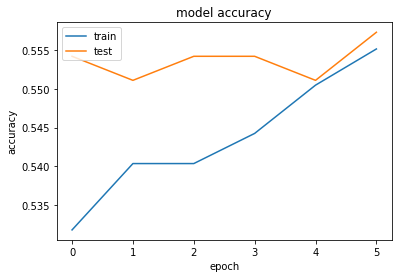

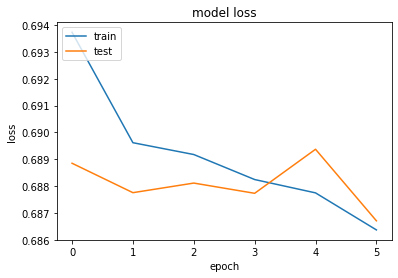

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Try different model, e.g. a Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

model = Sequential()

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 2, activation='relu'))#kernel size = n_inputs * n_outputs
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            333150    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 46, 128)           32128     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 365,536
Trainable params: 32,386
Non-trainable params: 333,150
_________________________________________________________________
None


In [ ]:
#fit model to training data
history = model.fit(x_train_tr, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)
#test model on test data
score = model.evaluate(x_test_tr, y_test, verbose=1)
#check model performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Epoch 1/5
11/11 [==============================] - 0s 27ms/step - loss: 0.7165 - acc: 0.4891 - val_loss: 0.6957 - val_acc: 0.5542
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 0.6784 - acc: 0.5567 - val_loss: 0.6948 - val_acc: 0.5294
Epoch 3/5
11/11 [==============================] - 0s 17ms/step - loss: 0.6569 - acc: 0.6102 - val_loss: 0.6960 - val_acc: 0.5542
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.6436 - acc: 0.6312 - val_loss: 0.6996 - val_acc: 0.5325
Epoch 5/5
12/12 [==============================] - 0s 3ms/step - loss: 0.7126 - acc: 0.5185
Test Score: 0.7126448154449463
Test Accuracy: 0.5185185074806213


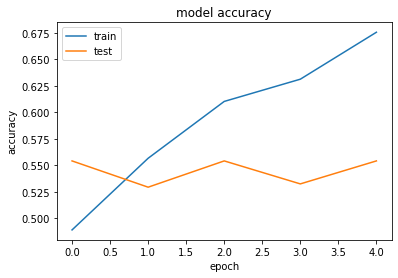

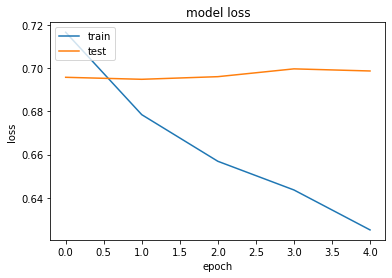

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Try last model, simple NN

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 50)            333150    
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2501      
Total params: 335,651
Trainable params: 2,501
Non-trainable params: 333,150
_________________________________________________________________
None


In [ ]:
#fit model to training data
history = model.fit(x_train_tr, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)
#test model on test data
score = model.evaluate(x_test_tr, y_test, verbose=1)
#check model performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/5
11/11 [==============================] - 0s 13ms/step - loss: 0.7375 - acc: 0.5031 - val_loss: 0.7248 - val_acc: 0.4861
Epoch 2/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6814 - acc: 0.5497 - val_loss: 0.7187 - val_acc: 0.4892
Epoch 3/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6560 - acc: 0.6017 - val_loss: 0.7148 - val_acc: 0.5294
Epoch 4/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6373 - acc: 0.6320 - val_loss: 0.7147 - val_acc: 0.5356
Epoch 5/5
12/12 [==============================] - 0s 1ms/step - loss: 0.7311 - acc: 0.5397
Test Score: 0.7310597896575928
Test Accuracy: 0.5396825671195984


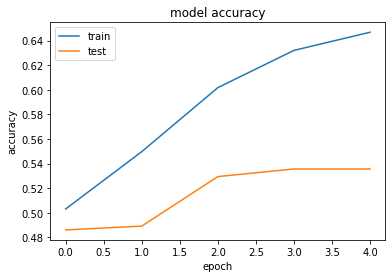

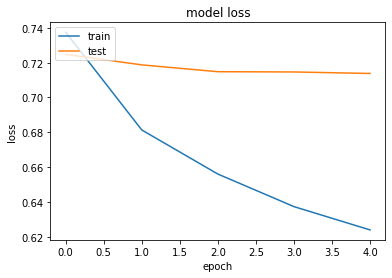

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()